In [55]:
!pip install transformers[torch]

In [ ]:
import logging
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Ensure transformers' logger propagates to the root logger
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.INFO)
transformers_logger.propagate = True

In [56]:
model_checkpoint = "google/vit-base-patch16-224"
batch_size = 32 # batch size for training and evaluation

In [57]:
!pip install -q datasets transformers

In [58]:
from datasets import load_dataset
dataset = load_dataset("STEM-AI-mtl/City_map", split="train")

In [59]:
from datasets import load_metric

metric = load_metric("accuracy")

c:\Users\William\anaconda3\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [60]:
example = dataset[0]

In [61]:
example['text']

'Amsterdam'

In [62]:
dataset.features['text']

Value(dtype='string', id=None)

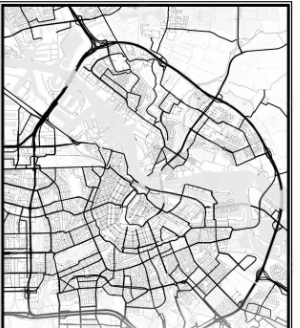

In [63]:
example['image']

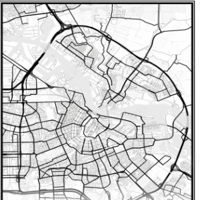

In [64]:
example['image'].resize((200, 200))

In [65]:
dataset.features["text"]

Value(dtype='string', id=None)

In [66]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [67]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

In [68]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")


In [69]:
train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

In [70]:
def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

In [71]:
def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [72]:
from datasets import Dataset
import PIL

clean_examples = {'image': [], 'text': []}
skipped_images = 0

for i in range(len(dataset)):
    try:
        example = dataset[i]
        image = example['image']
        clean_examples['image'].append(image)
        clean_examples['text'].append(example['text'])
    except PIL.UnidentifiedImageError:

        print(f"Error processing image {i}: UnidentifiedImageError")
        skipped_images += 1
        continue
    except Exception as e:

        print(f"Error processing image {i}: {e}")
        skipped_images += 1
        continue


clean_dataset = Dataset.from_dict(clean_examples)

print(f"Number of skipped images: {skipped_images}")

In [73]:
splits = clean_dataset.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [74]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

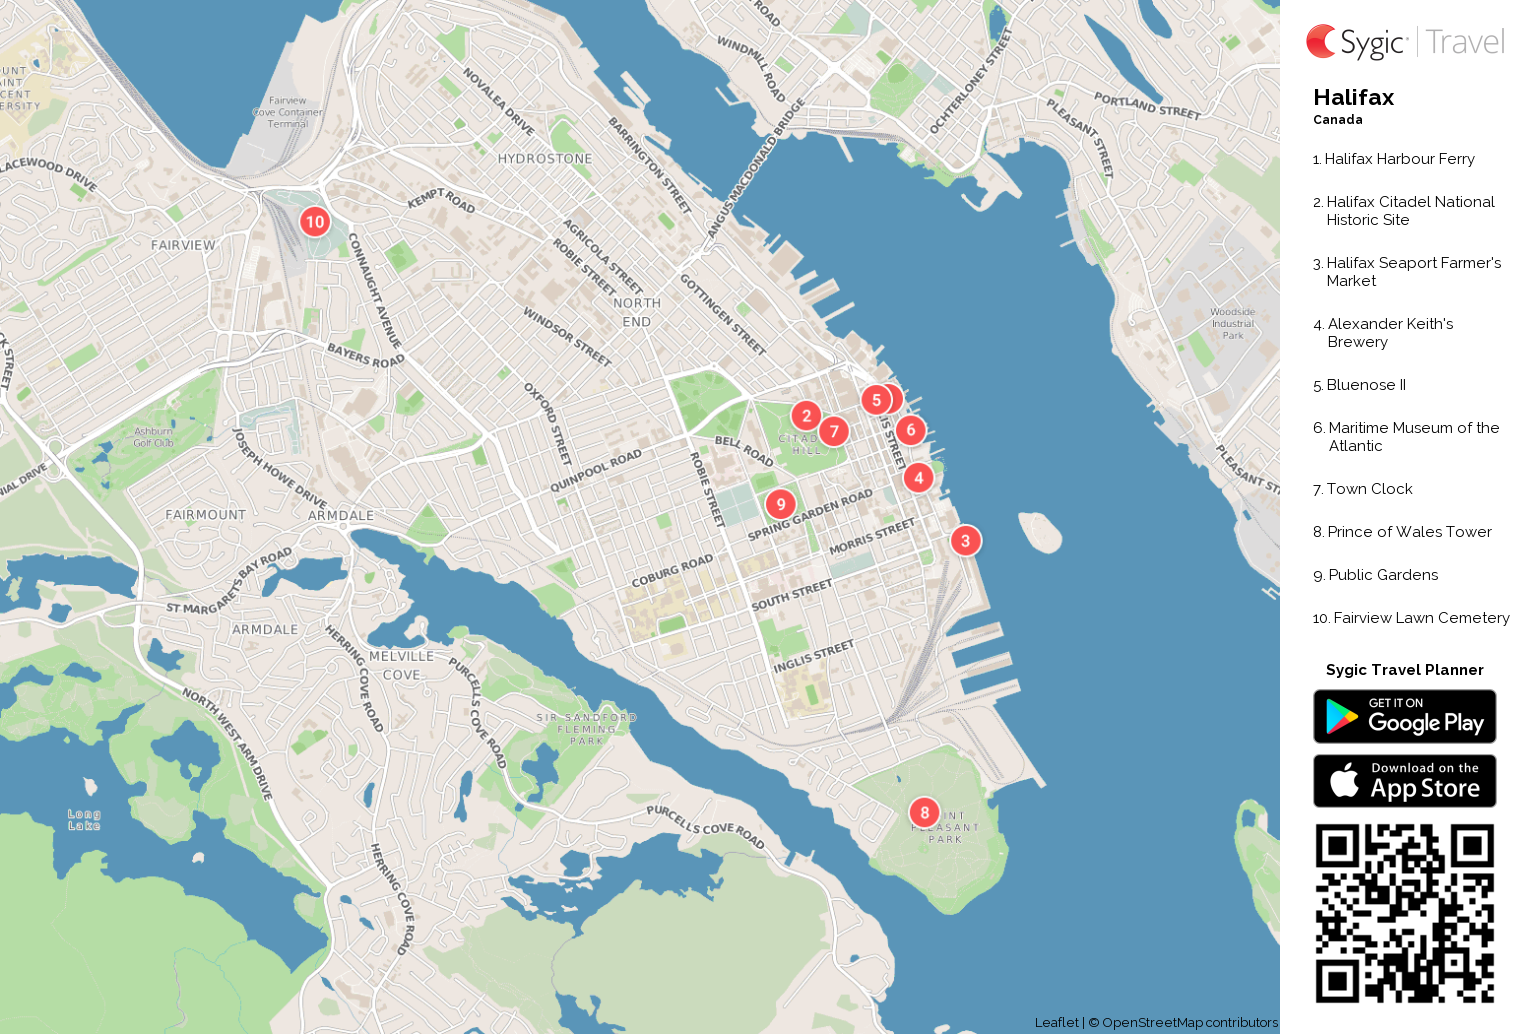

In [75]:
train_ds[0]['image']

In [76]:
clean_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 594
})

In [77]:
unique_labels = set(clean_dataset['text'])

label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for i, label in enumerate(unique_labels)}


In [78]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [220]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

In [221]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [222]:
unique_labels = set(clean_dataset['text'])

# Create a label map
label_map = {label: i for i, label in enumerate(unique_labels)}

In [223]:
import torch

In [224]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    # Convert string labels to numerical labels
    labels = [label_map[example["text"]] for example in examples]
    labels = torch.tensor(labels, dtype=torch.long)

    return {"pixel_values": pixel_values, "labels": labels}


In [225]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [226]:
print(type(trainer.train_dataset))


In [227]:
print(trainer.train_dataset[0])


In [228]:
print(type(trainer.model))

In [229]:
print(trainer.model.config)

In [230]:
train_results = trainer.train()

  0%|          | 0/12 [00:00<?, ?it/s]

c:\Users\William\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\William\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [231]:
eval_results = trainer.evaluate()

  0%|          | 0/2 [00:00<?, ?it/s]

In [232]:
eval_results

{'eval_loss': 3.903012752532959,
 'eval_accuracy': 0.016666666666666666,
 'eval_runtime': 12.9047,
 'eval_samples_per_second': 4.649,
 'eval_steps_per_second': 0.155,
 'epoch': 2.82}

In [233]:
!pip install -U "huggingface_hub[cli]"

In [234]:
!pip install huggingface_hub

In [235]:
#from huggingface_hub import notebook_login
#notebook_login()

In [236]:
#repo_name = f"STEM-AI-mtl/City_map-{model_name}"
#model.push_to_hub(repo_name)